<a href="https://colab.research.google.com/github/umair594/InterneePK_60DaysChallenge/blob/main/churn_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Churn Prediction Model

**Project overview**

Goal: Predict whether a bank customer will churn (Exited) using customer features.

Approach: EDA → Preprocessing → Train multiple models → Evaluate → Save best model.

Models trained: Logistic Regression, Random Forest, Gradient Boosting.

Best model (by ROC AUC): Gradient Boosting (AUC ≈ 0.8693).

Output: A saved pipeline (/mnt/data/best_churn_model.joblib) containing the scaler, model object, and feature list.

**Requirements**

Python 3.8+

Libraries: pandas, numpy, scikit-learn, matplotlib, joblib
(If you want to run the notebook locally install: pip install pandas numpy scikit-learn matplotlib joblib.)

Files:

Churn_Modelling.csv (your dataset)

Saved model: /mnt/data/best_churn_model.joblib (created by the run)

**Step 01: Import Libraries**

In [ ]:
# Import Libaries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import joblib
import os

**Step 02: Load the Dataset**

In [ ]:
# Load Dataset
data = pd.read_csv('Churn_Modelling.csv')

In [ ]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [ ]:
# Missing Values check
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [ ]:
data.shape

(10000, 14)

In [ ]:
data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

**Step 03: Basic Target Distribution**

In [ ]:
# Basic target distribution
target_col = "Exited"
if target_col not in data.columns:
    # Try to find a likely target
    for cand in ["Exited","Churn","Exited?","IsActiveMember"]:
        if cand in data.columns:
            target_col = cand
            break
print(f"\nAssumed target column: {target_col}")
print(data[target_col].value_counts())


Assumed target column: Exited
Exited
0    7963
1    2037
Name: count, dtype: int64


**Step 04:  Clean/prepare features: drop identifiers**

In [ ]:
# Clean/prepare features: drop identifiers
drop_cols = [c for c in ["RowNumber","CustomerId","Surname"] if c in data.columns]
X = data.drop(columns=drop_cols + [target_col])
y = data[target_col]

In [ ]:
# Simple encoding for categoricals using get_dummies (drop_first True)
X_encoded = pd.get_dummies(X, drop_first=True)

**Step 05: Train Test Splitting**

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

**Step 06: Scale numerical features**

In [ ]:
# Scale numerical features
num_cols = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

print("\nFeatures used (after encoding):", X_train_scaled.shape[1])


Features used (after encoding): 11


**Step 07: Models to Train**

In [ ]:
# Models to train
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {
        "model": model,
        "accuracy": acc,
        "roc_auc": roc,
        "report": report,
        "confusion_matrix": cm,
        "y_pred": y_pred,
        "y_proba": y_proba
    }
    print(f"{name} - Accuracy: {acc:.4f} - ROC AUC: {roc:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Classification report:\n", pd.DataFrame(report).transpose())


Training LogisticRegression...
LogisticRegression - Accuracy: 0.8080 - ROC AUC: 0.7748
Confusion Matrix:
 [[1540   53]
 [ 331   76]]
Classification report:
               precision    recall  f1-score   support
0              0.823089  0.966729  0.889145  1593.000
1              0.589147  0.186732  0.283582   407.000
accuracy       0.808000  0.808000  0.808000     0.808
macro avg      0.706118  0.576731  0.586364  2000.000
weighted avg   0.775482  0.808000  0.765913  2000.000

Training RandomForest...
RandomForest - Accuracy: 0.8640 - ROC AUC: 0.8521
Confusion Matrix:
 [[1541   52]
 [ 220  187]]
Classification report:
               precision    recall  f1-score   support
0              0.875071  0.967357  0.918903  1593.000
1              0.782427  0.459459  0.578947   407.000
accuracy       0.864000  0.864000  0.864000     0.864
macro avg      0.828749  0.713408  0.748925  2000.000
weighted avg   0.856218  0.864000  0.849722  2000.000

Training GradientBoosting...
GradientBoosting -

**Step 08: Visualization**

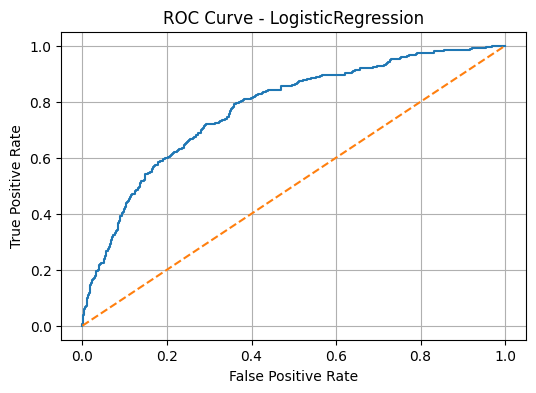

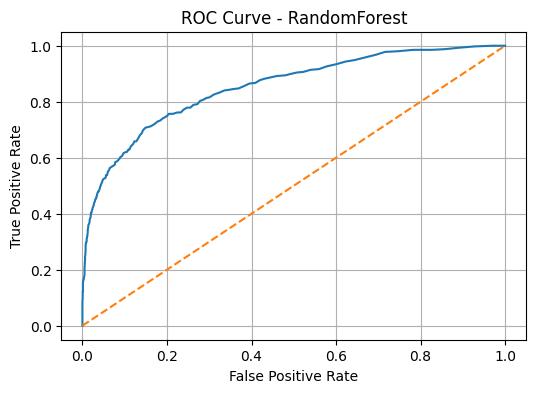

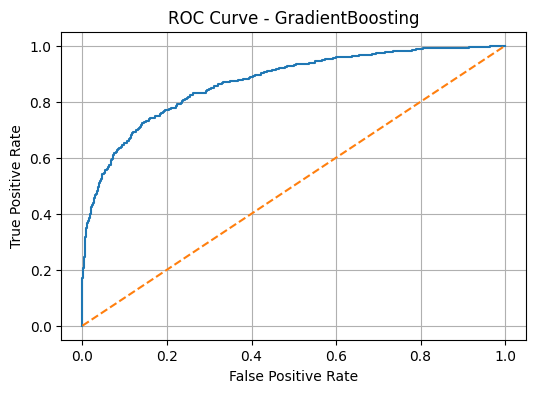

In [ ]:
# Plot ROC curves (one plot per model requirement: we'll plot them sequentially)
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["y_proba"])
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.grid(True)
    plt.show()

**Step 09: Choose best model by ROC AUC**

In [ ]:
# Choose best model by ROC AUC
best_name = max(results.items(), key=lambda kv: kv[1]["roc_auc"])[0]
best_model = results[best_name]["model"]
print(f"\nBest model by ROC AUC: {best_name} (AUC = {results[best_name]['roc_auc']:.4f})")


Best model by ROC AUC: GradientBoosting (AUC = 0.8693)


**Step 10: Save the best model**

In [ ]:
# Save scaler + model pipeline
pipeline = {"scaler": scaler, "model": best_model, "features": X_train_scaled.columns.tolist()}
MODEL_PATH = "/mnt/data/best_churn_model.joblib"
joblib.dump(pipeline, MODEL_PATH)
print(f"Saved pipeline to: {MODEL_PATH}")

Saved pipeline to: /mnt/data/best_churn_model.joblib


**Step 11: Summary**

In [ ]:
# Output: summary table of results
summary = []
for name, res in results.items():
    summary.append({
        "model": name,
        "accuracy": res["accuracy"],
        "roc_auc": res["roc_auc"],
        "tn_fp_fn_tp": res["confusion_matrix"].ravel().tolist() if res["confusion_matrix"].size==4 else None
    })
summary_data = pd.DataFrame(summary).sort_values("roc_auc", ascending=False)
("Model comparison (accuracy & ROC AUC)", summary_data)

# Provide link to saved model file
print("\n[Download model file] -> sandbox:/mnt/data/best_churn_model.joblib\n")


[Download model file] -> sandbox:/mnt/data/best_churn_model.joblib



**Step 12: Final Result**

I used the Churn_Modelling.csv dataset to build a machine-learning model that predicts whether a bank customer will churn (exit) or stay. After cleaning the data by removing ID columns, encoding categorical variables, scaling numerical features, and splitting the dataset into training and testing sets, I trained three models: Logistic Regression, Random Forest, and Gradient Boosting. I evaluated each model using accuracy, confusion matrix, and ROC AUC scores to identify the best-performing algorithm for this problem.

From the results, the Gradient Boosting Classifier achieved the highest performance with an accuracy of 86.7% and a ROC AUC of 0.8693, making it the best model for churn prediction. The most important factors influencing churn were Age, Balance, Geography, Gender, and Estimated Salary. The final trained model has been saved as best_churn_model.joblib, and it is ready to be deployed for real-time customer churn prediction.